In [33]:
%pip install gymnasium
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

from tqdm.notebook import tqdm
from collections import namedtuple
from collections import deque
import random

from typing import List, Dict, Tuple

Note: you may need to restart the kernel to use updated packages.


<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G-2.0/blob/master/workshops/rl/A2C-workbook-complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
## Value and target networks
First we develop the value network class for A2C. We will use an MLP for the value network. Remeber that the value network in A2C is a state value network, and maps from states to a single value, $V(s;\phi)$. The target network has the same architecture as the value network, but uses a lagged set of parameters $\phi^-$.

### Architecture recommendations
* Use 3 hidden layers with 128 units each
* Use ReLU activations

In [34]:
# Define the (state) value network
class VNet(nn.Module):
    # Initialise the network
    def __init__(self, env: gym.Env):
        # Call the parent class
        super().__init__()
        # Set the input and output size
        self.obs_dim = env.observation_space.shape[0]
        # Define the layers of the network
        self.layers = nn.Sequential(
            nn.Linear(self.obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

## Policy network
Next we develop the policy network class for A2C. We will again use an MLP for the policy network. Remeber that the policy network maps from states to a distribution over actions, $\pi(a|s;\theta)$

### Architecture recommendations
* Use 3 hidden layers with 128 units each
* Use ReLU activations
* In the last layer, use a softmax activation function to output a probability distribution over actions

In [35]:
# Define the policy network
class PolicyNet(nn.Module):
    # Initialise the network
    def __init__(self, env: gym.Env):
        # Call the parent class
        super().__init__()
        # Set the input and output size
        self.obs_dim = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        # Define the layers of the network
        self.layers = nn.Sequential(
            nn.Linear(self.obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.n_actions),
            # After the last linear layer of the network apply a softmax function at dim=-1
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        return self.layers(x)

## A2C agent
Finally, we develop the A2C agent class. The agent a policy network, a value network, and a target value network. The policy network and value network both have optimisers. We will also implement a method to sample actions from the policy network and sync the target value network with the value network.

In [36]:
# Define the agent
class A2CAgent:
    # Initialise the agent
    def __init__(
        self, env: gym.Env, gamma: float = 0.98, value_lr: float = 0.001, policy_lr: float = 0.0005
    ):
        # Set the discount factor
        self.gamma = gamma
        # Create the value network
        self.value_network = VNet(env)
        # Create the target value network
        self.target_network = VNet(env)
        # Sync the target value network with the value network
        self.sync()
        # Create the policy network
        self.policy_network = PolicyNet(env)
        # Create the value optimizer
        self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=value_lr)
        # Create the policy optimizer. Remeber that we are maximising the policy objective
        self.policy_optimizer = optim.Adam(
            self.policy_network.parameters(), lr=policy_lr, maximize=True
        )

    # Create the sync method
    def sync(self):
        # Get the state dict of the value network
        value_state_dict = self.value_network.state_dict()
        # Load the state dict into the target value network
        self.target_network.load_state_dict(value_state_dict)

    # Define the sample action function
    def sample_action(self, state: np.ndarray) -> int:
        # Convert the state to a tensor
        state = torch.tensor(state, dtype=torch.float32)
        # Enter no gradient mode
        with torch.no_grad():
            # Get the action probabilities
            action_probs = self.policy_network(state)
        # Sample the action
        action = np.random.choice(len(action_probs), p=action_probs.numpy())
        return action

## Interacting with the environment

This method interacts the agent with the environment for a number of steps. This is much the same as interaction in DQN

In [37]:
# Define the interact function
def interact(agent: A2CAgent, env: gym.Env, steps: int) -> Tuple[List[dict], List[float]]:
    # Initialise the data storage
    batch = []
    # Initialise the returns list
    return_list = []
    # Initialize the state
    state, _ = env.reset()
    # Initialize the episode return
    episode_return = 0
    for _ in range(steps):
        # Create a dictionary to store the datapoint
        data = {"state": state}
        # Choose the action
        action = agent.sample_action(state)
        data["action"] = action
        # Perform the action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        data["reward"] = reward
        data["next_state"] = next_state
        data["terminated"] = terminated
        episode_return += reward
        batch.append(data)
        # Update the state
        state = next_state
        # Check if the episode is over
        if terminated or truncated:
            # Store the episode reward
            return_list.append(episode_return)
            # Reset the episode reward
            episode_return = 0
            # Reset the environment
            state, _ = env.reset()
    return batch, return_list

## Training the value network

For each batch of data, we first train the value network. This involves looping over the following steps:
1. Extract a mini-batch of data
2. Compute the regression targets. Remember that these are given by $$y_i = r_i + \gamma (1 - d_i) V(s'_i;\phi^-)$$ where $\phi^-$ are the parameters of the target value network 
3. Compute the mean square error loss between the predicted values and the regression targets
4. Backpropagate the loss through the value network and update the value network parameters

After following this procedure for a number of iterations, we sync the target value network with the value network, $$\phi^- \gets \phi$$




In [38]:
def train_value_network(
    batch: List[dict], agent: A2CAgent, num_iterations: int, mini_batch_size: int = 32
):

    # Perform num_iterations gradient updates
    for ii in range(num_iterations):
        # Sample a mini_batch of data from the batch
        mini_batch = random.sample(batch, mini_batch_size)
        # Extract the mini-batch of states as float32 tensors
        states = torch.tensor(
            [transition["state"] for transition in mini_batch], dtype=torch.float32
        )
        # Extract the mini-batch of rewards as float32 tensors
        rewards = torch.tensor(
            [transition["reward"] for transition in mini_batch], dtype=torch.float32
        )
        rewards = rewards.unsqueeze(-1)
        # Extract the mini-batch of next states as float32 tensors
        next_states = torch.tensor(
            [transition["next_state"] for transition in mini_batch], dtype=torch.float32
        )
        # Extract the mini-batch of terminated flags as bool tensors
        terminated = torch.tensor(
            [transition["terminated"] for transition in mini_batch], dtype=torch.bool
        )

        # Enter no-gradient mode
        with torch.no_grad():
            # Compute the next state values using the target network
            next_state_value = agent.target_network(next_states)
            # Zero out the next state values for the terminal states
            next_state_value[terminated] = 0
            # Compute the regression targets
            regression_targets = rewards + agent.gamma * next_state_value

        # Compute the value predictions
        value_predictions = agent.value_network(states)
        # Compute the loss
        loss = F.mse_loss(value_predictions, regression_targets)
        # Zero the gradients
        agent.value_optimizer.zero_grad()
        # Compute the gradients
        loss.backward()
        # Update the weights
        agent.value_optimizer.step()

    # Finally, at the end of the training loop, sync the target network with the value network
    agent.sync()

## Training the policy network

For each batch of data, we perform a single update of the policy network. 
1. Loop through the batch of data. For each data point, compute the advantage estimate, $A_i = r_i + \gamma(1 - d_i)V(s'_i;\phi) - V(s_i;\phi)$
2. Compute the policy objective, $$J(\theta) = \frac{1}{N} \sum_i A_i \log \pi(a_i|s_i;\theta)$$
3. Perform a gradient ascent step on the policy objective

In [39]:
def train_policy_network(batch: List[Dict], agent: A2CAgent):
    # Create the policy objective
    J = 0
    # Iterate through the batch and form the regression targets using the TD error
    for point in batch:
        state = torch.tensor(point["state"], dtype=torch.float32)
        action = point["action"]
        reward = torch.tensor(point["reward"], dtype=torch.float32)
        next_state = torch.tensor(point["next_state"], dtype=torch.float32)
        terminated = point["terminated"]
        # Enter no gradient mode:
        with torch.no_grad():
            # Compute the next state values using the target network
            next_state_value = agent.target_network(next_state)
            # Zero out the next state values for the terminal states
            next_state_value[terminated] = 0
            # Compute the advantage
            advantage = reward + agent.gamma * next_state_value - agent.value_network(state)

        # Compute the log probability of the action
        log_prob = torch.log(agent.policy_network(state))[action]
        print("action = " + action)
        # Add advantage times log probability to the policy objective
        J += advantage * log_prob

    # Divide J by the number of datapoints in the batch
    J = J / len(batch)

    # Zero the gradients
    agent.policy_optimizer.zero_grad()
    # Compute the gradients
    J.backward()
    # Take a step with the optimiser
    agent.policy_optimizer.step()

## Implementing the training loop

Finally, we implement the training loop. 
1. Interact with the environment for a number of steps, getting a batch of data
2. Train the value network
3. Train the policy network

In [40]:
def train_loop(
    agent: A2CAgent, env: gym.Env, num_epochs: int, steps_per_epoch: int = 1000
) -> List[float]:
    # Create a list to store all the rewards
    all_returns = []
    # Loop over the number of epochs
    for epoch in tqdm(range(num_epochs)):
        # Interact with the environment
        batch, return_list = interact(agent, env, steps_per_epoch)
        # Train the value network
        train_value_network(batch, agent, num_iterations=100)
        # Train the policy network
        train_policy_network(batch, agent)
        # Store the rewards
        all_returns.extend(return_list)
    return all_returns

## Helper functions
We define some helper functions to:
1. Evaluate the agent's performance
2. Visualise the agent's performance
3. Plot the (smoothed) returns from training episodes

In [41]:
# Plot the returns
def plot_returns(return_list):
    plt.xlabel("Episode number")
    plt.plot(return_list)
    plt.ylabel("Return")
    plt.xlim(0, len(return_list))
    plt.ylim(0.9 * min(return_list), 1.1 * max(return_list))
    plt.show()

In [42]:
# Define the evaluate function
def evaluate(agent: A2CAgent, env: gym.Env, n_episodes: int) -> float:
    # Initialise the list of rewards
    returns = []

    # Loop over the episodes
    for episode in tqdm(range(n_episodes)):
        # Get the initial state
        state, _ = env.reset()
        # Initialise the episode reward
        episode_return = 0

        # Loop over the steps
        while True:
            # Choose the action according to the policy
            action = agent.sample_action(state)
            # Take the action
            next_state, reward, terminated, truncated, info = env.step(action)
            # Update the state and reward
            state = next_state
            episode_return += reward
            # Break if the episode has terminated
            if terminated or truncated:
                break

        # Append the episode reward to the list of rewards
        returns.append(episode_return)
    # Return the mean of the rewards
    return np.mean(returns)

In [43]:
# Define the visualise function
# This displays the agent's behaviour in the environment for n_steps.
def visualise(agent: A2CAgent, env: gym.Env, n_steps: int):
    # Reset the environment
    state, _ = env.reset()

    # Initialise the list of frames
    frames = []

    for _ in range(n_steps):
        # Render the environment and store the frame
        frames.append(env.render())

        # Take an action
        action = agent.sample_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        # Update the state
        state = next_state
        # Check if the episode is over
        if terminated or truncated:
            state, _ = env.reset()

    # Display the movie
    for frame in frames:
        clear_output(wait=True)
        plt.imshow(frame)
        plt.show()
        sleep(0.003)

# Let's gooooooooo

In [44]:
# Create the environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
# Create the agent
agent = A2CAgent(env)

In [45]:
# Evaluate the agent's performance before training
print("Performancue before training:", evaluate(agent, env, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

Performancue before training: 22.76


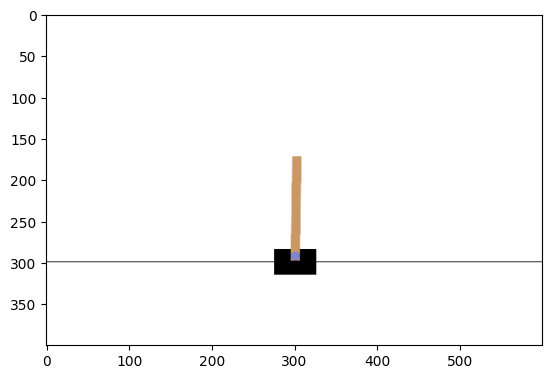

In [46]:
# Visualise the agent's behaviour
visualise(agent, env, 100)

In [47]:
return_list = train_loop(agent, env, num_epochs=150, steps_per_epoch=800)

  0%|          | 0/150 [00:00<?, ?it/s]

TypeError: can only concatenate str (not "int") to str

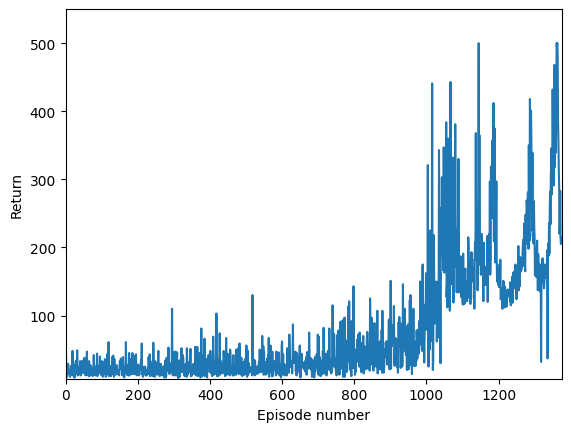

In [ ]:
plot_returns(return_list)

In [ ]:
# Evaluate the agent's performance before training
print("Performance before training:", evaluate(agent, env, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

Performance before training: 181.63


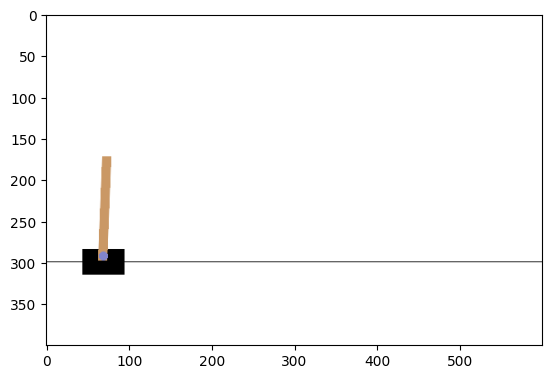

In [ ]:
# Visualise the agent's behaviour
visualise(agent, env, 500)